# Regression task: the time interval between two consecutive visits for the same patient ~ ICD diagnosis code

## Prepare the dataset

In [1]:
""" 
Patient ID -> admission ID
"""

' \nPatient ID -> admission ID\n'

In [4]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from datetime import datetime
from mimic_common import *
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import gaussian_process



In [5]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/mimic")
print(f"Will save outputs to {output_dir}")
data_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/mimic_exp/mimiciii")
print(f"Will read data from {data_dir}")

Will save outputs to /home/wanxinli/deep_patient/outputs/mimic
Will read data from /home/wanxinli/deep_patient/mimic_exp/mimiciii


In [4]:
admission_file = os.path.join(data_dir, "ADMISSIONS.csv")
diagnosis_file = os.path.join(data_dir, "DIAGNOSES_ICD.csv")
patient_file = os.path.join(data_dir, "PATIENTS.csv")

In [5]:
pid_adms, pid_gender, adm_date, admid_codes, pid_visits = build_maps(admission_file, diagnosis_file, patient_file)


In [6]:
# print(pid_visits)

In [7]:
# construct codes (ICD codes for the first visits), and durations (time interval until the next visit)

codes = []
durations = []
genders = []
for pid, visits in pid_visits.items():
    for i, cur_visit in enumerate(visits):
        if i == len(visits)-1: # stop on the last element
            break 
        next_visit = visits[i+1]
        # print(next_visit)
        cur_codes = cur_visit[1]
        # print(codes)
        duration = (next_visit[0]-cur_visit[0]).total_seconds()
        codes.append(cur_codes)
        durations.append(duration)
        genders.append(pid_gender[pid])


cons_visits_df = pd.DataFrame(columns=['gender', 'duration', 'ICD codes'])
cons_visits_df['gender'] = genders
cons_visits_df['duration'] = durations
cons_visits_df['ICD codes'] = codes
cons_visits_df.to_csv(os.path.join(output_dir, "CONS_VISITS.csv"), index=False, header=True)

cons_visits_df

,gender,duration,ICD codes
0,M,130162740.0,"[41401, 4111, 4241, V4582, 2724, 4019, 60000, ..."
1,M,145197420.0,"[41071, 4280, 4254, 42731, 9971, 4260, 41401, ..."
2,M,1082040.0,"[41401, 4111, 496, 4019, 3051, 53081, 60000, V..."
3,M,94491660.0,"[99831, 99811, 41511, 4538, 99672, 496, 41401,..."
4,M,20640960.0,"[5715, 5722, 2867, 45620, 3453, 48241, 51881, ..."
...,...,...,...
12451,M,9735840.0,"[42731, 56211, V1051]"
12452,M,8103720.0,"[99859, 0389, 99592, 78552, 5849, 5990, 42830,..."
12453,F,2644440.0,"[4373, 4019, 2449, 59651, 49390, V1052]"
12454,F,1994400.0,"[5363, 5641]"


In [8]:
""" 
Outputs consecutive visit stats
"""
female_count = cons_visits_df.loc[(cons_visits_df['gender'] == 'F')].shape[0]
male_count = cons_visits_df.loc[(cons_visits_df['gender'] == 'M')].shape[0]
print("female count is:", female_count)
print("male count is:", male_count)

female count is: 5627
male count is: 6829


In [9]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var[-1])
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var[-1])

    return target_reps, source_reps

In [10]:
n_components = 50
model_func = linear_model.PoissonRegressor
entire_proc_cts(n_components, cons_visits_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=True)

Cummulative variance explained by the source PCA is: 0.755495723084281
Cummulative variance explained by the target PCA is: 0.8131456752772201


(17421156.05769769,
 28350771.68052116,
 82613436.15748748,
 235862761.98573396,
 44393488.61807839,
 66183401.0068247)

In [11]:
model_func = linear_model.LinearRegression
entire_proc_cts(n_components, cons_visits_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=False)

(24776890.458302394,
 39047675.79740884,
 47346694.31845031,
 65809642.51912538,
 44273838.195116475,
 65239815.89045127)

In [12]:
""" 
Run multiple iterations using Poisson regression
"""

score_path = os.path.join(output_dir, "exp5_poisson_score_"+str(n_components)+".csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, cons_visits_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.PoissonRegressor, iteration=100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 17
iteration: 18
iteration: 19


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 20
iteration: 21


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 72
iteration: 73


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 74
iteration: 75
iteration: 76
iteration: 77
iteration: 78


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 79
iteration: 80
iteration: 81
iteration: 82
iteration: 83
iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92
iteration: 93
iteration: 94
iteration: 95
iteration: 96
iteration: 97
iteration: 98
iteration: 99


array([[1.80728742e+07, 2.93788092e+07, 1.29625694e+08, 5.58758496e+08,
        4.39286085e+07, 6.74203552e+07],
       [1.82865668e+07, 2.90512162e+07, 7.96427113e+07, 2.96065133e+08,
        4.29794723e+07, 6.73787605e+07],
       [1.74702545e+07, 2.86347400e+07, 6.94516756e+07, 1.84624426e+08,
        4.51687137e+07, 6.94293509e+07],
       [1.62590554e+07, 2.69487692e+07, 9.65552864e+07, 4.07810536e+08,
        4.31093305e+07, 6.53453362e+07],
       [1.78462550e+07, 2.85381872e+07, 1.23489127e+08, 7.13101213e+08,
        4.15178198e+07, 6.56688237e+07],
       [1.52430781e+07, 2.47710216e+07, 1.06589979e+08, 3.95850005e+08,
        4.50551254e+07, 7.01932398e+07],
       [1.80031509e+07, 2.96918404e+07, 7.56506411e+07, 1.98058001e+08,
        4.48714974e+07, 6.75038029e+07],
       [1.75636263e+07, 2.88380415e+07, 7.79458003e+07, 2.30311555e+08,
        4.46018438e+07, 6.88029685e+07],
       [1.83329139e+07, 3.03226127e+07, 7.17828709e+07, 1.72721415e+08,
        4.44070696e+07, 

In [13]:
# score_path = os.path.join(output_dir, "exp5_poisson_score_"+str(n_components)+".csv")

# save_path = "../../outputs/mimic/exp5_poisson_res.png"

# box_plot_cts_short(score_path, save_path=save_path)

In [14]:
""" 
Run multiple iterations using Linear regression
"""

score_path = os.path.join(output_dir, "exp5_linear_score_"+str(n_components)+".csv")
multi_proc_cts(score_path, n_components, cons_visits_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.LinearRegression, iteration=100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 7
iteration: 8
iteration: 9
iteration: 10


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 48
iteration: 49
iteration: 50


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 51
iteration: 52
iteration: 53


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 54
iteration: 55
iteration: 56


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
iteration: 73
iteration: 74
iteration: 75
iteration: 76
iteration: 77
iteration: 78
iteration: 79
iteration: 80
iteration: 81


/home/wanxinli/miniconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 82
iteration: 83
iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92
iteration: 93
iteration: 94
iteration: 95
iteration: 96
iteration: 97
iteration: 98
iteration: 99


array([[25499308.38620298, 38966151.60342804, 50645281.41142448,
        70236478.24852021, 49397757.44391252, 68327135.83854823],
       [25185134.78615885, 38979461.39526469, 48451002.85664381,
        65917958.6648282 , 48698928.95242132, 68272298.65781783],
       [24869899.72610937, 38617704.30342472, 52864968.97553156,
        71689311.44992635, 50013313.7852822 , 69982776.30509268],
       [25320705.11795004, 39293090.22082678, 48906497.66056307,
        68679605.6491971 , 47585193.06956747, 68386790.13351746],
       [25162167.32399892, 39541867.39466517, 46644350.61837894,
        65643587.07706738, 46562248.12743689, 65473470.70506906],
       [25003084.67871913, 38839118.10207657, 48827914.50091853,
        67245852.4590953 , 49190217.87908883, 69360596.77437378],
       [24456269.02226322, 38262890.88310087, 49343274.47930967,
        67134930.95423843, 47972898.99609926, 67713190.64816488],
       [25382634.37149608, 39807102.26848953, 47874595.59441045,
        65671952.9

In [15]:
# score_path = os.path.join(output_dir, "exp5_linear_score.csv")
# save_path = "../../outputs/mimic/exp5_linear_res.png"

# box_plot_cts_short(score_path, save_path=save_path)

KeyError: 'trans_source_mae'

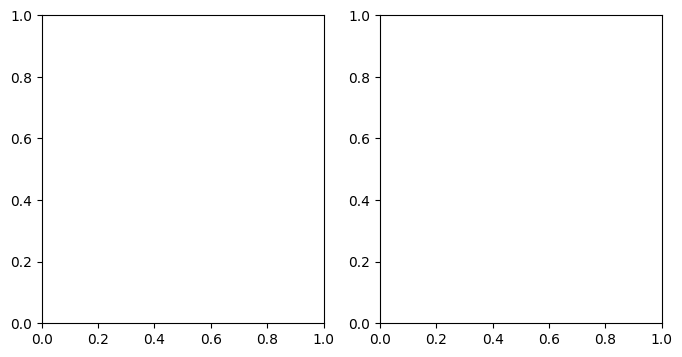

In [16]:
def special_div(x, y):
    """ 
    Special division operation
    """
    if y == 0:
        y = 1e-5
    return x/y

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(4)
fig.set_figwidth(8)
title_size = 15
text_size = 12

# plt.subplot(1,2,1)
score_path = os.path.join(output_dir, "exp5_linear_score_"+str(n_components)+".csv")

scores_df = pd.read_csv(score_path, index_col=None, header=0)

source_mae = scores_df['source_mae']
source_rmse = scores_df['source_rmse']

trans_source_mae = scores_df['trans_source_mae']
trans_source_rmse = scores_df['trans_source_rmse']

# transported source to source mae
trans_source_source_mae = [special_div(i, j) for i, j in zip(trans_source_mae, source_mae)]

# transported source to source rmse
trans_source_source_rmse = [special_div(i, j) for i, j in zip(trans_source_rmse, source_rmse)]


# Pandas dataframe
data = pd.DataFrame({
    'MAE': trans_source_source_mae,
    'RMSE': trans_source_source_rmse
})

# Plot the dataframe
ax = data[['MAE', 'RMSE']].plot(kind='box', ax=axes[0])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0, 1.2)
ax.set_title("(a) Linear", fontweight='bold', loc='left', fontsize=title_size)

######################################################

score_path = os.path.join(output_dir, "exp5_poisson_score_"+str(n_components)+".csv")

scores_df = pd.read_csv(score_path, index_col=None, header=0)

source_mae = scores_df['source_mae']
source_rmse = scores_df['source_rmse']

trans_source_mae = scores_df['trans_source_mae']
trans_source_rmse = scores_df['trans_source_rmse']

# transported source to source mae
trans_source_source_mae = [special_div(i, j) for i, j in zip(trans_source_mae, source_mae)]

# transported source to source rmse
trans_source_source_rmse = [special_div(i, j) for i, j in zip(trans_source_rmse, source_rmse)]


# Pandas dataframe
data = pd.DataFrame({
    'MAE': trans_source_source_mae,
    'RMSE': trans_source_source_rmse
})

# Plot the dataframe
ax = data[['MAE', 'RMSE']].plot(kind='box', ax=axes[1])

# Plot the baseline
ax.axhline(y = 1, color = 'r', linestyle = '-')

ax.tick_params(labelsize=text_size)
ax.set_ylim(0, 1.2)
plt.title("(b) Poisson", fontweight='bold', loc='left', fontsize=title_size)
plt.tight_layout()

save_path = os.path.join(output_dir, "exp5_res_"+str(n_components)+".pdf")
plt.savefig(save_path, bbox_inches='tight')
plt.show()

mae ratio using linear is: 0.04593307024834281
mae ratio std using linear is: 0.037985538133659506
rmse ratio using linear is: 0.009272498648004168
rmse ratio std using linear is: 0.030339909705367193
mae ratio using poisson is: 0.46554303761056914
mae ratio std using poisson is: 0.11065913728880965
rmse ratio using poisson is: 0.7211892340365226
rmse ratio std using poisson is: 0.12289071687024683
mae ratio to TCA using linear is: 0.04439330235414207
mae ratio std to TCA using linear is: 0.043188605708400725
rmse ratio to TCA using linear is: -0.0015107916075369765
rmse ratio std to TCA using linear is: 0.03811281336836391
mae ratio to TCA using poisson is: 0.11128952186956709
mae ratio std to TCA using poisson is: 0.03884722397207354
rmse ratio to TCA using poisson is: -0.012080487962987885
rmse ratio std to TCA using poisson is: 0.036260405951806775


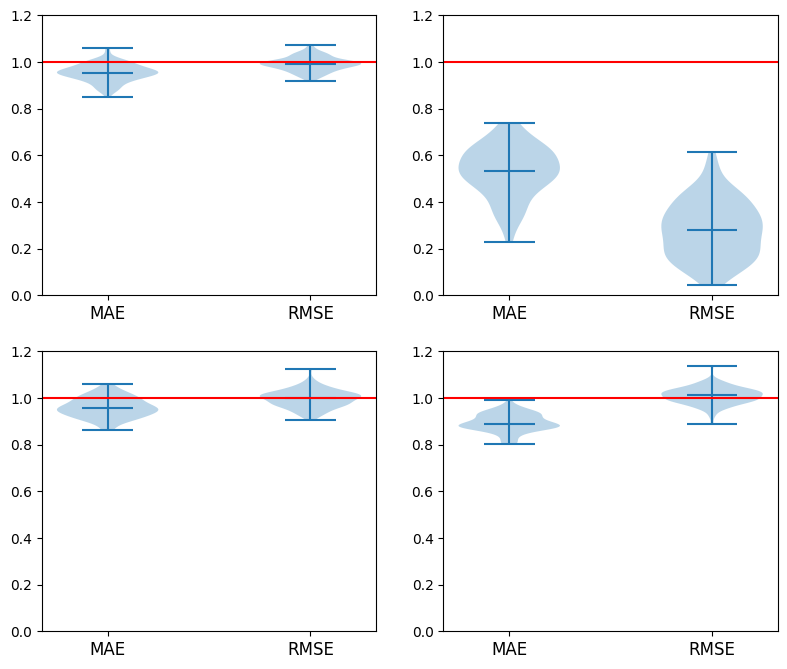

In [6]:
""" 
Combine plots for MIMIC experiment 5 together
"""
n_components = 50
def special_div(x, y):
    """ 
    Special division operation
    """
    if y == 0:
        y = 1e-5
    return x/y

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(9.5)
title_size = 15
text_size = 12
y_min = 0
y_max = 1.2
linear_score_path = os.path.join(output_dir, "exp5_linear_score_"+str(n_components)+".csv")

linear_scores_df = pd.read_csv(linear_score_path, index_col=None, header=0)

target_mae = linear_scores_df['target_mae']
target_rmse = linear_scores_df['target_rmse']

trans_target_mae = linear_scores_df['trans_target_mae']
trans_target_rmse = linear_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(trans_target_mae, target_mae)]
print("mae ratio using linear is:", 1-median(trans_target_target_mae))
print("mae ratio std using linear is:", np.std(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(trans_target_rmse, target_rmse)]
print("rmse ratio using linear is:", 1-median(trans_target_target_rmse))
print("rmse ratio std using linear is:", np.std(trans_target_target_rmse))


# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
axes[0][0].violinplot(data, showmedians=True)

# Plot the baseline
axes[0][0].axhline(y = 1, color = 'r', linestyle = '-')
axes[0][0].set_xticks([1,2])
axes[0][0].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)
axes[0][0].set_ylim(y_min, y_max)
# axes[0][0].set_title(r"$\bf{(a)}$ Compared to w.o. transport"+"\n using Linear", x=0.37, fontsize=title_size)


######################################################

poisson_score_path = os.path.join(output_dir, "exp5_poisson_score_"+str(n_components)+".csv")

poisson_scores_df = pd.read_csv(poisson_score_path, index_col=None, header=0)

target_mae = poisson_scores_df['target_mae']
target_rmse = poisson_scores_df['target_rmse']

trans_target_mae = poisson_scores_df['trans_target_mae']
trans_target_rmse = poisson_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(trans_target_mae, target_mae)]
print("mae ratio using poisson is:", 1-median(trans_target_target_mae))
print("mae ratio std using poisson is:", np.std(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(trans_target_rmse, target_rmse)]
print("rmse ratio using poisson is:", 1-median(trans_target_target_rmse))
print("rmse ratio std using poisson is:", np.std(trans_target_target_rmse))


# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe

axes[0][1].violinplot(data, showmedians=True)

# Plot the baseline
axes[0][1].axhline(y = 1, color = 'r', linestyle = '-')
axes[0][1].set_xticks([1,2])
axes[0][1].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)
axes[0][1].set_ylim(y_min, y_max)
# axes[0][1].set_title(r"$\bf{(b)}$ Compared to w.o. transport"+"\n using Poisson", x=0.37, fontsize=title_size)

#####################################################
tca_linear_score_path = os.path.join(output_dir, "exp5_tca_linear_score.csv")

tca_linear_scores_df = pd.read_csv(tca_linear_score_path, index_col=None, header=0)

ot_target_mae = linear_scores_df['trans_target_mae']
ot_target_rmse = linear_scores_df['trans_target_rmse']

tca_target_mae = tca_linear_scores_df['trans_target_mae']
tca_target_rmse = tca_linear_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(ot_target_mae, tca_target_mae)]
print("mae ratio to TCA using linear is:", 1-median(trans_target_target_mae))
print("mae ratio std to TCA using linear is:", np.std(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(ot_target_rmse, tca_target_rmse)]
print("rmse ratio to TCA using linear is:", 1-median(trans_target_target_rmse))
print("rmse ratio std to TCA using linear is:", np.std(trans_target_target_rmse))

# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe

axes[1][0].violinplot(data, showmedians=True)

# Plot the baseline
axes[1][0].axhline(y = 1, color = 'r', linestyle = '-')
axes[1][0].set_xticks([1,2])
axes[1][0].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)
axes[1][0].set_ylim(y_min, y_max)
# axes[1][0].set_title(r"$\bf{(c)}$ Compared to TCA using Linear", x=0.42, fontsize=title_size)


####################################################
tca_poisson_score_path = os.path.join(output_dir, "exp5_tca_poisson_score.csv")

tca_poisson_scores_df = pd.read_csv(tca_linear_score_path, index_col=None, header=0)

ot_target_mae = poisson_scores_df['trans_target_mae']
ot_target_rmse = poisson_scores_df['trans_target_rmse']

tca_target_mae = tca_poisson_scores_df['trans_target_mae']
tca_target_rmse = tca_poisson_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(ot_target_mae, tca_target_mae)]
print("mae ratio to TCA using poisson is:", 1-median(trans_target_target_mae))
print("mae ratio std to TCA using poisson is:", np.std(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(ot_target_rmse, tca_target_rmse)]
print("rmse ratio to TCA using poisson is:", 1-median(trans_target_target_rmse))
print("rmse ratio std to TCA using poisson is:", np.std(trans_target_target_rmse))

# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
axes[1][1].violinplot(data, showmedians=True)

# Plot the baseline
axes[1][1].axhline(y = 1, color = 'r', linestyle = '-')
axes[1][1].set_xticks([1,2])
axes[1][1].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)

axes[1][1].set_ylim(y_min, y_max)
# axes[1][1].set_title(r"$\bf{(d)}$ Compared to TCA using Poisson", x=0.45, fontsize=title_size)
save_path = os.path.join(output_dir, "exp5_res.pdf")
plt.savefig(save_path, bbox_inches='tight')